In [7]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ABIDE

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ABIDE


In [8]:
!pip install nilearn

from nilearn.image import load_img
from nilearn.datasets import fetch_atlas_schaefer_2018
from nilearn.input_data import NiftiLabelsMasker
import numpy as np
from scipy.spatial.distance import squareform
import tensorflow as tf
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, precision_recall_fscore_support
from tqdm import tqdm
from PIL import ImageFile


In [9]:
# Fetch the atlas with 100 regions of interest (ROIs)
atlas = fetch_atlas_schaefer_2018(n_rois=100)
masker = NiftiLabelsMasker(labels_img=atlas.maps, standardize=True)

[get_dataset_dir] Dataset found in /root/nilearn_data/schaefer_2018

In [10]:
imaging_files = os.listdir("func_preproc")
print(f"Number of imaging files: {len(imaging_files)}")
print("First 10 imaging files:", imaging_files[:10])


Number of imaging files: 257
First 10 imaging files: ['Pitt_0050014_func_preproc.nii.gz', 'Pitt_0050025_func_preproc.nii.gz', 'Pitt_0050041_func_preproc.nii.gz', 'Pitt_0050042_func_preproc.nii.gz', 'Pitt_0050045_func_preproc.nii.gz', 'Pitt_0050047_func_preproc.nii.gz', 'Pitt_0050052_func_preproc.nii.gz', 'Olin_0050104_func_preproc.nii.gz', 'Olin_0050107_func_preproc.nii.gz', 'Olin_0050112_func_preproc.nii.gz']


In [11]:
# Function to extract subject ID from the filename
def get_id(name):
    parts = name.split('_')
    for part in parts:
        if part.isdigit():
            return part.lstrip('0')  # Strip leading zeros
    return None


# Load the phenotypic data
# phenotypic_data = pd.read_csv('Updated_Phenotypic_V1_0b_preprocessed1_corrected_version2.csv')
phenotypic_data = pd.read_csv('Phenotypic_V1_0b_preprocessed1.csv')
phenotypic_data['SUB_ID'] = phenotypic_data['SUB_ID'].astype(str).str.strip()

# List of fMRI files
imaging_files = os.listdir("func_preproc")

# Extract IDs from imaging files
image_ids = [get_id(f) for f in imaging_files if get_id(f)]
print(f"First 10 extracted image IDs: {image_ids[:10]}")

# Ensure there are no None values
# image_ids = [id_ for id_ in image_ids if id_ is not None]

# Check the first few `SUB_ID`s in phenotypic data
print("First 10 SUB_IDs in phenotypic data:", phenotypic_data['SUB_ID'])

First 10 extracted image IDs: ['50014', '50025', '50041', '50042', '50045', '50047', '50052', '50104', '50107', '50112']
First 10 SUB_IDs in phenotypic data: 0       50002
1       50003
2       50004
3       50005
4       50006
        ...  
1107    51583
1108    51584
1109    51585
1110    51606
1111    51607
Name: SUB_ID, Length: 1112, dtype: object


In [12]:
fmri_directory = '/content/drive/MyDrive/ABIDE/func_preproc'
fmri_files = os.listdir(fmri_directory)
print(f"Files in '{fmri_directory}':")
print(fmri_files)


Files in '/content/drive/MyDrive/ABIDE/func_preproc':
['Pitt_0050014_func_preproc.nii.gz', 'Pitt_0050025_func_preproc.nii.gz', 'Pitt_0050041_func_preproc.nii.gz', 'Pitt_0050042_func_preproc.nii.gz', 'Pitt_0050045_func_preproc.nii.gz', 'Pitt_0050047_func_preproc.nii.gz', 'Pitt_0050052_func_preproc.nii.gz', 'Olin_0050104_func_preproc.nii.gz', 'Olin_0050107_func_preproc.nii.gz', 'Olin_0050112_func_preproc.nii.gz', 'Olin_0050118_func_preproc.nii.gz', 'Olin_0050125_func_preproc.nii.gz', 'Olin_0050133_func_preproc.nii.gz', 'OHSU_0050143_func_preproc.nii.gz', 'OHSU_0050144_func_preproc.nii.gz', 'OHSU_0050153_func_preproc.nii.gz', 'OHSU_0050166_func_preproc.nii.gz', 'OHSU_0050168_func_preproc.nii.gz', 'OHSU_0050169_func_preproc.nii.gz', 'OHSU_0050170_func_preproc.nii.gz', 'SDSU_0050182_func_preproc.nii.gz', 'SDSU_0050187_func_preproc.nii.gz', 'SDSU_0050188_func_preproc.nii.gz', 'SDSU_0050190_func_preproc.nii.gz', 'SDSU_0050191_func_preproc.nii.gz', 'SDSU_0050194_func_preproc.nii.gz', 'SDSU_005

In [ ]:
file_to_check = 'Pitt_0050041_func_preproc.nii.gz'
if file_to_check in fmri_files:
    print(f"File '{file_to_check}' exists in '{fmri_directory}'.")
else:
    print(f"File '{file_to_check}' does NOT exist in '{fmri_directory}'.")


File 'Pitt_0050041_func_preproc.nii.gz' exists in '/content/drive/MyDrive/ABIDE/func_preproc'.


In [13]:
# Match phenotypic data with imaging data
matched_data = phenotypic_data[phenotypic_data['SUB_ID'].isin(image_ids)].reset_index(drop=True)
print(f"Number of matched subjects: {len(matched_data)}")


Number of matched subjects: 182


In [16]:
# Change current working directory
os.chdir('/content/drive/MyDrive/ABIDE')
print(f"Current working directory: {os.getcwd()}")


Current working directory: /content/drive/MyDrive/ABIDE


In [17]:
# Copy fMRI files from Google Drive to Colab's local directory for more reliable access
fmri_directory_drive = "/content/drive/MyDrive/ABIDE/func_preproc"
local_directory = "/content/func_preproc"
if not os.path.exists(local_directory):
    os.makedirs(local_directory)

imaging_files = os.listdir(fmri_directory_drive)
for fmri_file in imaging_files:
    shutil.copy(f"{fmri_directory_drive}/{fmri_file}", local_directory)

In [ ]:
# # Fetch the atlas
# masker = NiftiLabelsMasker(labels_img=atlas.maps, standardize=True)
# scaler = StandardScaler()

# def gen_features_and_labels(data, target_feature):
#     # Initialize feature and label lists
#     features_list = []
#     labels_list = []

#     # Loop through matched data to extract features
#     for idx, row in tqdm(matched_data.iterrows(), total=matched_data.shape[0]):
#         sub_id = row['SUB_ID']
#         fmri_file = next((f for f in imaging_files if sub_id in f), None)
#         if fmri_file:
#             fmri_file_path = f"/content/func_preproc/{fmri_file}"
#             if os.path.exists(fmri_file_path):
#                 try:
#                     # Load the fMRI image
#                     fmri_img = load_img(fmri_file_path)
#                     # Extract time series data using the atlas-based masker
#                     time_series = masker.fit_transform(fmri_img)

#                     # Replace NaNs/Infs in time series
#                     time_series = np.nan_to_num(time_series, nan=0.0, posinf=0.0, neginf=0.0)

#                     # Compute the correlation matrix
#                     correlation_matrix = np.corrcoef(time_series.T)

#                     # Replace NaNs/Infs in correlation matrix
#                     correlation_matrix = np.nan_to_num(correlation_matrix, nan=0.0, posinf=0.0, neginf=0.0)

#                     # Flatten the upper triangle of the correlation matrix to use as features
#                     features = squareform(correlation_matrix, checks=False)
#                     features_list.append(features)
#                     labels_list.append(row[target_feature])
#                 except (OSError, ConnectionAbortedError) as e:
#                     print(f"Error loading file '{fmri_file_path}': {e}")
#             else:
#                 print(f"File '{fmri_file_path}' does not exist.")
#         else:
#             print(f"No fMRI file found for subject {sub_id}")
#     return features_list, labels_list

# features_list, labels_list = gen_features_and_labels(matched_data, "DX_GROUP")



 39%|███▉      | 71/182 [06:41<10:56,  5.91s/it]/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 182/182 [16:26<00:00,  5.42s/it]


In [31]:
# Fetch the atlas
atlas = fetch_atlas_schaefer_2018(n_rois=100)
masker = NiftiLabelsMasker(labels_img=atlas.maps, standardize=True)
scaler = StandardScaler()

def gen_features_and_labels(data, target_feature):
    # Initialize feature and label lists
    features_list = []
    labels_list = []

    # Loop through matched data to extract features
    for idx, row in tqdm(matched_data.iterrows(), total=matched_data.shape[0]):
        sub_id = row['SUB_ID']
        fmri_file = next((f for f in imaging_files if sub_id in f), None)
        if fmri_file:
            fmri_file_path = f"/content/func_preproc/{fmri_file}"
            if os.path.exists(fmri_file_path):
                try:
                    # Load the fMRI image
                    fmri_img = load_img(fmri_file_path)
                    # Extract time series data using the atlas-based masker
                    time_series = masker.fit_transform(fmri_img)

                    # Replace NaNs/Infs in time series
                    time_series = np.nan_to_num(time_series, nan=0.0, posinf=0.0, neginf=0.0)

                    # Compute the correlation matrix
                    correlation_matrix = np.corrcoef(time_series.T)

                    # Replace NaNs/Infs in correlation matrix
                    correlation_matrix = np.nan_to_num(correlation_matrix, nan=0.0, posinf=0.0, neginf=0.0)

                    # Flatten the upper triangle of the correlation matrix to use as features
                    fmri_features = squareform(correlation_matrix, checks=False)

                    scaled_fmri_features = scaler.fit_transform(fmri_features.reshape(-1, 1)).flatten()  # reshape for 1D scaling

                    #Basic
                    pheno_variables = ["AGE_AT_SCAN", "SEX"]
                    #Extra
                    # extra_pheno_variables = ["AGE_AT_SCAN", "SEX","FIQ", "VIQ", "PIQ", "ADI_R_SOCIAL_TOTAL_A", "ADI_R_VERBAL_TOTAL_BV", "ADI_RRB_TOTAL_C", "ADI_R_ONSET_TOTAL_D", "ADI_R_RSRCH_RELIABLE", "ADOS_MODULE", "ADOS_TOTAL", "ADOS_COMM", "ADOS_SOCIAL", "ADOS_STEREO_BEHAV", "ADOS_RSRCH_RELIABLE"]
                    pheno_features = row[pheno_variables].values
                    pheno_features = np.array(pheno_features)
                    # numpy_extra_pheno_features = np.array(row[extra_pheno_variables].values)

                    scaled_pheno_features = scaler.fit_transform(pheno_features.reshape(-1, 1)).flatten()
                    pheno_weight = 1000
                    combined_features = np.concatenate((fmri_features, pheno_weight*scaled_pheno_features))

                    features_list.append(combined_features)
                    labels_list.append(row[target_feature])
                except (OSError, ConnectionAbortedError, ImageFileError) as e:
                    print(f"Error loading file '{fmri_file_path}': {e}")
            else:
                print(f"File '{fmri_file_path}' does not exist.")
        else:
            print(f"No fMRI file found for subject {sub_id}")
    return features_list, labels_list

features_list, labels_list = gen_features_and_labels(matched_data, "DX_GROUP")



[get_dataset_dir] Dataset found in /root/nilearn_data/schaefer_2018

 39%|███▉      | 71/182 [06:42<10:59,  5.94s/it]/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
 95%|█████████▌| 173/182 [15:35<00:41,  4.66s/it]/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 182/182 [16:25<00:00,  5.41s/it]


In [32]:
# Assuming feature extraction is complete and features_list and labels_list are populated

X = np.array(features_list)
y = np.array(labels_list)

# Encode labels: 1 -> 1 (ASD), 2 -> 0 (Control)
y_encoded = (y == 1).astype(int)

# Optional: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(type(y_encoded))
print(type(X_scaled))

In [34]:
print(len(features_list[0]))
# Define the learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr + 0.0001  # Gradually increase during warm-up
    return lr * 0.95  # Gradually decrease after epoch 10

#def run_model(X_scaled, y_encoded):

  # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Initialize cross-validation with StratifiedKFold
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
fold_accuracies = []

for train_idx, test_idx in kfold.split(X_scaled, y_encoded):
    X_train_fold, X_test_fold = X_scaled[train_idx], X_scaled[test_idx]
    y_train_fold, y_test_fold = y_encoded[train_idx], y_encoded[test_idx]

    # Compute class weights for the current fold
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_fold), y=y_train_fold)
    class_weights = dict(enumerate(class_weights))

    # Define a more complex model with LeakyReLU activations and increased number of units
    model = models.Sequential([
        layers.Input(shape=(X_train_fold.shape[1],)),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.1),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.1),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(64),
        layers.LeakyReLU(alpha=0.1),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(32),
        layers.LeakyReLU(alpha=0.1),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model with RMSprop optimizer
    model.compile(optimizer=RMSprop(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Early stopping callback with increased patience
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    # Learning rate scheduler callback
    lr_scheduler_callback = callbacks.LearningRateScheduler(lr_schedule, verbose=1)

    # Train the model
    history = model.fit(X_train_fold, y_train_fold,
                        epochs=72,
                        batch_size=32,
                        validation_data=(X_test_fold, y_test_fold),
                        class_weight=class_weights,
                        callbacks=[early_stopping, lr_scheduler_callback],
                        verbose=0)

    # Evaluate the model on the validation set
    score = model.evaluate(X_test_fold, y_test_fold, verbose=0)
    fold_accuracies.append(score[1])
    print(f"Fold Test Accuracy: {score[1] * 100:.2f}%")

# Print the average cross-validation accuracy
print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies) * 100:.2f}%")
#return model, X_test, y_test

  #model, X_test, y_test = run_model(X_scaled, y_encoded)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

4952
Training set size: 145 samples
Testing set size: 37 samples


TypeError: Singleton array array(3) cannot be considered a valid collection.

In [18]:

# Scores for receptive communication, expressive communication, written communication, interpersonal skills, coping skills, processing speed
personality_variables = ["VINELAND_RECEPTIVE_V_SCALED", "VINELAND_EXPRESSIVE_V_SCALED",
                        "VINELAND_WRITTEN_V_SCALED", "VINELAND_INTERPERSONAL_V_SCALED",
                        "VINELAND_COPING_V_SCALED", "WISC_IV_PSI"]

personality_dictionary = {
  "choleric": {"Pos":["WISC_IV_PSI"], "Neg": ["VINELAND_RECEPTIVE_V_SCALED", "VINELAND_INTERPERSONAL_V_SCALED", "VINELAND_COPING_V_SCALED"]},
  "sanguine": {"Pos":["VINELAND_EXPRESSIVE_V_SCALED", "VINELAND_INTERPERSONAL_V_SCALED"], "Neg": ["VINELAND_WRITTEN_V_SCALED"]},
  "phlegmatic": {"Pos":["VINELAND_RECEPTIVE_V_SCALED", "VINELAND_COPING_V_SCALED"], "Neg": ["WISC_IV_PSI"]},
  "melancholic": {"Pos":["VINELAND_WRITTEN_V_SCALED"], "Neg": ["VINELAND_EXPRESSIVE_V_SCALED"]}
}

def standardise_all(variables, phenotypic_data):
  for variable in variables:
    phenotypic_data[variable + "_STANDARD"] = (phenotypic_data[variable] - phenotypic_data[variable].mean())/phenotypic_data[variable].std()
  return phenotypic_data

def get_personality_score(personality_type, personality_dictionary, row):
  pos = np.mean([row[variable + "_STANDARD"] for variable in personality_dictionary[personality_type]["Pos"]])
  neg = np.mean([row[variable + "_STANDARD"] for variable in personality_dictionary[personality_type]["Neg"]])
  return pos - neg

def get_personality(personality_dictionary, row):
  choleric_score = get_personality_score("choleric", personality_dictionary, row)
  sanguine_score = get_personality_score("sanguine", personality_dictionary, row)
  phlegmatic_score = get_personality_score("phlegmatic", personality_dictionary, row)
  melancholic_score = get_personality_score("melancholic", personality_dictionary, row)
  if max(choleric_score, sanguine_score, phlegmatic_score, melancholic_score) == choleric_score:
    return "choleric"
  if max(choleric_score, sanguine_score, phlegmatic_score, melancholic_score) == sanguine_score:
    return "sanguine"
  if max(choleric_score, sanguine_score, phlegmatic_score, melancholic_score) == phlegmatic_score:
    return "phlegmatic"
  if max(choleric_score, sanguine_score, phlegmatic_score, melancholic_score) == melancholic_score:
    return "melancholic"

def get_personalities(personality_dictionary, phenotypic_data):
  personalities = []
  for idx, row in tqdm(phenotypic_data.iterrows(), total=phenotypic_data.shape[0]):
    personalities.append(get_personality(personality_dictionary, row))
  return personalities

def add_personalities(personality_dictionary, phenotypic_data):
  for idx, row in tqdm(phenotypic_data.iterrows(), total=phenotypic_data.shape[0]):
    phenotypic_data.loc[idx, "PERSONALITY"] = get_personality(personality_dictionary, row)
    phenotypic_data.loc[idx, "choleric_score"] = get_personality_score("choleric", personality_dictionary, row)
    phenotypic_data.loc[idx, "sanguine_score"] = get_personality_score("sanguine", personality_dictionary, row)
    phenotypic_data.loc[idx, "phlegmatic_score"] = get_personality_score("phlegmatic", personality_dictionary, row)
    phenotypic_data.loc[idx, "melancholic_score"] = get_personality_score("melancholic", personality_dictionary, row)
  return phenotypic_data

matched_data = standardise_all(personality_variables, matched_data)
personality_labels = get_personalities(personality_dictionary, matched_data)
matched_data = add_personalities(personality_dictionary, matched_data)
phenotypic_data.to_csv("with_personalities.csv", encoding='utf-8')


100%|██████████| 182/182 [00:00<00:00, 737.64it/s]


In [24]:

from sklearn.utils import class_weight

personality_matched_data = matched_data.drop(personality_variables, axis=1)
print(f"Number of matched subjects: {len(personality_matched_data)}")

print(type(personality_matched_data))
print(type(matched_data))


features_list, labels_list = gen_features_and_labels(personality_matched_data, "PERSONALITY")

import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from scipy.sparse import issparse

Number of matched subjects: 182
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


 39%|███▉      | 71/182 [05:58<09:50,  5.32s/it]/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
 95%|█████████▌| 173/182 [13:54<00:36,  4.05s/it]/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 182/182 [14:38<00:00,  4.83s/it]


In [25]:

old_labels_list = labels_list

import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from scipy.sparse import issparse

def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr + 0.0001  # Gradually increase during warm-up
    return lr * 0.95  # Gradually decrease after epoch 10

personality_mapping = {
    "choleric": 0,
    "sanguine": 1,
    "phlegmatic": 2,
    "melancholic": 3
}

print(labels_list)
labels_list = [personality_mapping.get(label, -1) for label in labels_list]

X = np.array(features_list)
y = np.array(labels_list)

print(labels_list)

arr = np.array(labels_list)
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(max(labels_list)+1))
y_encoded = label_binarizer.transform(arr)
print('{0}'.format(y_encoded))



# # Optional: Normalize features
# scaler = StandardScaler()
# X_scaled = np.asarray(scaler.fit_transform(X))

# print(type(X_scaled))
# print(type(y_encoded))

# layers.Dense(y_encoded.shape[1], activation='softmax')  # Softmax for multi-class
# model.compile(optimizer=RMSprop(learning_rate=0.0005),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# from sklearn.utils.class_weight import compute_class_weight

# # Compute class weights using integer labels
# y_integers = np.argmax(y_encoded, axis=1)  # Convert one-hot to integers
# class_weights = compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)
# class_weights = dict(enumerate(class_weights))
# 5. Adjust Metrics for Validation
# Evaluation during training will still rely on accuracy, but you might also track per-class performance later using precision, recall, or F1-score.
# predictions = model.predict(X_test)
# predicted_classes = np.argmax(predictions, axis=1)  # Predicted class indices

# if issparse(X_scaled):
#     X_scaled = X_scaled.toarray()

# # Ensure y_encoded is also dense, if applicable
# if issparse(y_encoded):
#     y_encoded = y_encoded.toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
fold_accuracies = []
precision_scores = []
recall_scores = []
f1_scores = []

for train_idx, test_idx in kfold.split(X, np.argmax(y_encoded, axis=1)):
    X_train_fold, X_test_fold = X[train_idx], X[test_idx]
    y_train_fold, y_test_fold = y_encoded[train_idx], y_encoded[test_idx]

    class_weights = class_weight.compute_class_weight('balanced',
                                          classes=np.unique(np.argmax(y_train_fold, axis=1)),
                                          y=np.argmax(y_train_fold, axis=1))
    class_weights = dict(enumerate(class_weights))

    class_weights = {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

    # unique_classes = np.arange(y_encoded.shape[1])  # Ensure all classes are included
    # class_weights = class_weight.compute_class_weight(
    #     'balanced',
    #     classes=unique_classes,
    #     y=np.argmax(y_train_fold, axis=1)
    # )
    # class_weights = dict(enumerate(class_weights))


    model = models.Sequential([
        layers.Input(shape=(X_train_fold.shape[1],)),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.1),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.1),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(64),
        layers.LeakyReLU(alpha=0.1),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(32),
        layers.LeakyReLU(alpha=0.1),
        layers.BatchNormalization(),
        layers.Dense(y_encoded.shape[1], activation='softmax')  # Softmax output
    ])

    model.compile(optimizer=RMSprop(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    lr_scheduler_callback = callbacks.LearningRateScheduler(lr_schedule, verbose=1)

    history = model.fit(X_train_fold, y_train_fold,
                        epochs=60,
                        batch_size=32,
                        validation_data=(X_test_fold, y_test_fold),
                        class_weight=class_weights,
                        callbacks=[early_stopping, lr_scheduler_callback],
                        verbose=0)

    # Evaluate model on validation fold
    score = model.evaluate(X_test_fold, y_test_fold, verbose=0)
    fold_accuracies.append(score[1])

    # Predict on validation data
    predictions = model.predict(X_test_fold)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test_fold, axis=1)


    # Get unique classes in this fold
    unique_classes_in_fold = np.unique(true_classes)

    # Get target names for the unique classes in this fold
    target_names_in_fold = [label_binarizer.classes_[i] for i in unique_classes_in_fold]
    #label_binarizer is the fitted LabelBinarizer from earlier in your code.
    #This line ensures target_names match the classes actually present in the fold.

    # # Classification report with updated target names
    # report = classification_report(true_classes, predicted_classes, target_names=target_names_in_fold)
    # print(report)


    # # Classification report
    # report = classification_report(true_classes, predicted_classes, target_names=encoder.categories_[0])
    # print(report)

    # Compute per-fold precision, recall, and F1
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f"Fold Test Accuracy: {score[1] * 100:.2f}%")

# Print average metrics
print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies) * 100:.2f}%")
print(f"Average Precision: {np.mean(precision_scores) * 100:.2f}%")
print(f"Average Recall: {np.mean(recall_scores) * 100:.2f}%")
print(f"Average F1-Score: {np.mean(f1_scores) * 100:.2f}%")

  #model, X_test, y_test = run_model(X_scaled, y_encoded)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
# run_model(X_scaled, y_encoded)

labels_list = old_labels_list

['sanguine', 'phlegmatic', 'phlegmatic', 'choleric', 'melancholic', 'sanguine', 'phlegmatic', 'sanguine', 'phlegmatic', 'melancholic', 'phlegmatic', 'sanguine', 'choleric', 'sanguine', 'choleric', 'melancholic', 'sanguine', 'phlegmatic', 'sanguine', 'melancholic', 'choleric', 'choleric', 'sanguine', 'choleric', 'sanguine', 'choleric', 'sanguine', 'sanguine', 'sanguine', 'sanguine', 'phlegmatic', 'sanguine', 'sanguine', 'melancholic', 'choleric', 'melancholic', 'melancholic', 'sanguine', 'melancholic', 'sanguine', 'phlegmatic', 'choleric', 'sanguine', 'choleric', 'phlegmatic', 'phlegmatic', 'melancholic', 'phlegmatic', 'choleric', 'melancholic', 'melancholic', 'choleric', 'melancholic', 'choleric', 'melancholic', 'choleric', 'melancholic', 'choleric', 'choleric', 'sanguine', 'melancholic', 'choleric', 'melancholic', 'choleric', 'sanguine', 'choleric', 'melancholic', 'sanguine', 'choleric', 'choleric', 'melancholic', 'melancholic', 'phlegmatic', 'melancholic', 'choleric', 'choleric', 'me

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [30]:
labels_list = old_labels_list
old_labels_list = labels_list
print(old_labels_list)
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from scipy.sparse import issparse

def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr + 0.0001  # Gradually increase during warm-up
    return lr * 0.95  # Gradually decrease after epoch 10

personality_mapping = {
    "choleric": 0,
    "sanguine": 1,
    "phlegmatic": 2,
    "melancholic": 3
}

print(labels_list)
#labels_list = [personality_mapping.get(label, -1) for label in labels_list]

# Replace any missing or unexpected values in labels_list with a default value
# This ensures all labels are valid for the mapping
default_label = "choleric"  # or any other valid label
labels_list = [personality_mapping.get(label, personality_mapping[default_label]) for label in labels_list]

# Print labels_list after mapping to check for any unexpected values
print("Labels list after mapping:", labels_list)

X = np.array(features_list)
y = np.array(labels_list)

# Replace any NaN or inf values in features
X = np.nan_to_num(X)

# Convert features to float32 data type
X = X.astype(np.float32)

print("Labels list before binarization:", labels_list)
arr = np.array(labels_list)
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(max(labels_list)+1))
y_encoded = label_binarizer.transform(arr)
print('{0}'.format(y_encoded))



# # Optional: Normalize features
# scaler = StandardScaler()
# X_scaled = np.asarray(scaler.fit_transform(X))

# print(type(X_scaled))
# print(type(y_encoded))

# layers.Dense(y_encoded.shape[1], activation='softmax')  # Softmax for multi-class
# model.compile(optimizer=RMSprop(learning_rate=0.0005),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# from sklearn.utils.class_weight import compute_class_weight

# # Compute class weights using integer labels
# y_integers = np.argmax(y_encoded, axis=1)  # Convert one-hot to integers
# class_weights = compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)
# class_weights = dict(enumerate(class_weights))
# 5. Adjust Metrics for Validation
# Evaluation during training will still rely on accuracy, but you might also track per-class performance later using precision, recall, or F1-score.
# predictions = model.predict(X_test)
# predicted_classes = np.argmax(predictions, axis=1)  # Predicted class indices

# if issparse(X_scaled):
#     X_scaled = X_scaled.toarray()

# # Ensure y_encoded is also dense, if applicable
# if issparse(y_encoded):
#     y_encoded = y_encoded.toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
fold_accuracies = []
precision_scores = []
recall_scores = []
f1_scores = []

for train_idx, val_idx in kfold.split(np.zeros(len(y_encoded)), np.argmax(y_encoded, axis=1)):
    # Select the corresponding folds for X and y
    X_train_fold, X_val_fold = X[train_idx], X[test_idx]
    y_train_fold, y_val_fold = y_encoded[train_idx], y_encoded[test_idx]

    # Compute class weights
    class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(np.argmax(y_train_fold, axis=1)),
        y=np.argmax(y_train_fold, axis=1)
    )
    class_weights = dict(enumerate(class_weights))

    # Optional: Override class weights as per your example
    class_weights = {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

    # Now train your model with X_train_fold, y_train_fold

    # unique_classes = np.arange(y_encoded.shape[1])  # Ensure all classes are included
    # class_weights = class_weight.compute_class_weight(
    #     'balanced',
    #     classes=unique_classes,
    #     y=np.argmax(y_train_fold, axis=1)
    # )
    # class_weights = dict(enumerate(class_weights))


    model = models.Sequential([
        layers.Input(shape=(X_train_fold.shape[1],)),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.1),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.1),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(64),
        layers.LeakyReLU(alpha=0.1),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(32),
        layers.LeakyReLU(alpha=0.1),
        layers.BatchNormalization(),
        layers.Dense(y_encoded.shape[1], activation='softmax')  # Softmax output
    ])

    model.compile(optimizer=RMSprop(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    lr_scheduler_callback = callbacks.LearningRateScheduler(lr_schedule, verbose=1)

    history = model.fit(X_train_fold, y_train_fold,
                        epochs=300,
                        batch_size=32,
                        validation_data=(X_test_fold, y_test_fold),
                        class_weight=class_weights,
                        callbacks=[early_stopping, lr_scheduler_callback],
                        verbose=0)

    # Evaluate model on validation fold
    score = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_accuracies.append(score[1])

    # Predict on validation data
    predictions = model.predict(X_test_fold)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test_fold, axis=1)


    # Get unique classes in this fold
    unique_classes_in_fold = np.unique(true_classes)

    # Get target names for the unique classes in this fold
    target_names_in_fold = [label_binarizer.classes_[i] for i in unique_classes_in_fold]
    #label_binarizer is the fitted LabelBinarizer from earlier in your code.
    #This line ensures target_names match the classes actually present in the fold.

    # # Classification report with updated target names
    # report = classification_report(true_classes, predicted_classes, target_names=target_names_in_fold)
    # print(report)


    # # Classification report
    # report = classification_report(true_classes, predicted_classes, target_names=encoder.categories_[0])
    # print(report)

    # Compute per-fold precision, recall, and F1
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f"Fold Test Accuracy: {score[1] * 100:.2f}%")

# Print average metrics
print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies) * 100:.2f}%")
print(f"Average Precision: {np.mean(precision_scores) * 100:.2f}%")
print(f"Average Recall: {np.mean(recall_scores) * 100:.2f}%")
print(f"Average F1-Score: {np.mean(f1_scores) * 100:.2f}%")

  #model, X_test, y_test = run_model(X_scaled, y_encoded)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
# run_model(X_scaled, y_encoded)

labels_list = old_labels_list

['sanguine', 'phlegmatic', 'phlegmatic', 'choleric', 'melancholic', 'sanguine', 'phlegmatic', 'sanguine', 'phlegmatic', 'melancholic', 'phlegmatic', 'sanguine', 'choleric', 'sanguine', 'choleric', 'melancholic', 'sanguine', 'phlegmatic', 'sanguine', 'melancholic', 'choleric', 'choleric', 'sanguine', 'choleric', 'sanguine', 'choleric', 'sanguine', 'sanguine', 'sanguine', 'sanguine', 'phlegmatic', 'sanguine', 'sanguine', 'melancholic', 'choleric', 'melancholic', 'melancholic', 'sanguine', 'melancholic', 'sanguine', 'phlegmatic', 'choleric', 'sanguine', 'choleric', 'phlegmatic', 'phlegmatic', 'melancholic', 'phlegmatic', 'choleric', 'melancholic', 'melancholic', 'choleric', 'melancholic', 'choleric', 'melancholic', 'choleric', 'melancholic', 'choleric', 'choleric', 'sanguine', 'melancholic', 'choleric', 'melancholic', 'choleric', 'sanguine', 'choleric', 'melancholic', 'sanguine', 'choleric', 'choleric', 'melancholic', 'melancholic', 'phlegmatic', 'melancholic', 'choleric', 'choleric', 'me

100%|██████████| 182/182 [00:00<00:00, 12586.37it/s]


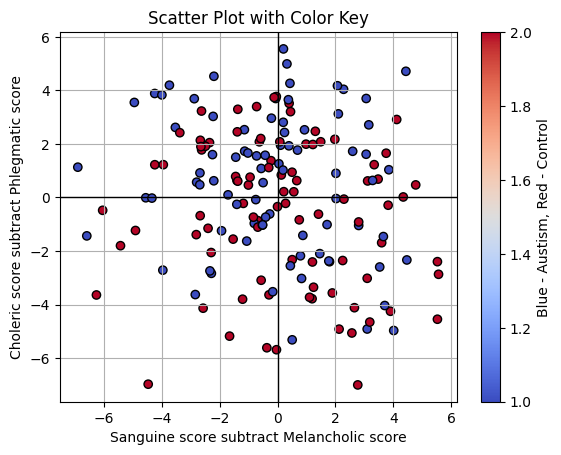

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([])
y = np.array([])
z = np.array([])

for idx, row in tqdm(matched_data.iterrows(), total=matched_data.shape[0]):
    x = np.append(x, row["sanguine_score"] - row["melancholic_score"])
    y = np.append(y, row["choleric_score"] - row["phlegmatic_score"])
    z = np.append(z, row["DX_GROUP"])

# Example data
# np.random.seed(0)
# x = np.random.randn(100)  # Random x values (both positive and negative)
# y = np.random.randn(100)  # Random y values (both positive and negative)
# z = x * y  # Example z values, which will be used to color the points

# Create the scatter plot with a color map
scatter = plt.scatter(x, y, c=z, cmap='coolwarm', edgecolors='k')

# Add a color bar (color key)
plt.colorbar(scatter, label='Blue - Austism, Red - Control')

# Add labels and title
plt.xlabel('Sanguine score subtract Melancholic score')
plt.ylabel('Choleric score subtract Phlegmatic score')
plt.title('Scatter Plot with Color Key')

# Show grid and adjust the axes to ensure positive and negative are both visible
plt.grid(True)
plt.axhline(0, color='black',linewidth=1)  # Horizontal line at y=0
plt.axvline(0, color='black',linewidth=1)  # Vertical line at x=0

# Show the plot
plt.show()

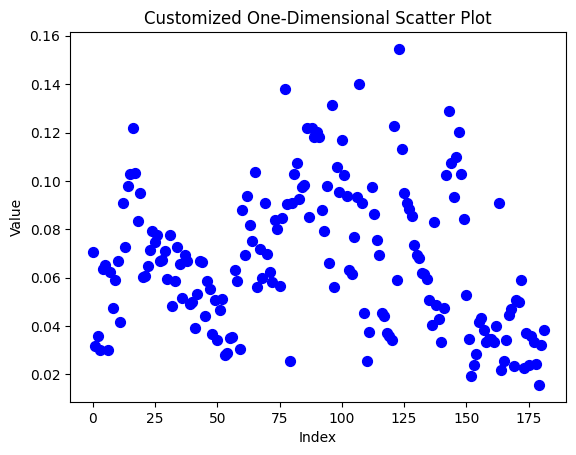

In [ ]:
# Customizing the scatter plot
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(range(len(matched_data)), 1/matched_data["AGE_AT_SCAN"], color='blue', s=50, marker='o')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Customized One-Dimensional Scatter Plot')

# Show the plot
plt.show()

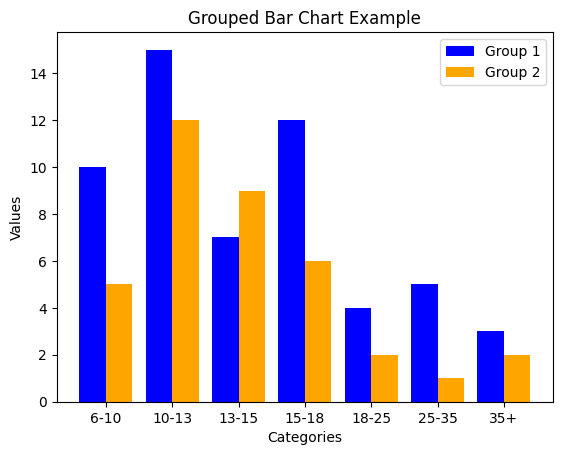

In [ ]:
# Example data
categories = ["6-10", "10-13", "13-15", "15-18", "18-25", "25-35", "35+"]
values1 = [10, 15, 7, 12,4,5,3]  # First set of values
values2 = [5, 12, 9, 6,2,1,2]    # Second set of values

# Number of categories
n = len(categories)

# Create an array of positions for the bars (0, 1, 2, 3 for example)
x = np.arange(n)

# Set the width of the bars
bar_width = 0.4

# Create the bars
plt.bar(x - bar_width/2, values1, width=bar_width, label='Group 1', color='blue')
plt.bar(x + bar_width/2, values2, width=bar_width, label='Group 2', color='orange')

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Grouped Bar Chart Example')

# Set the x-axis tick positions and labels
plt.xticks(x, categories)

# Add a legend
plt.legend()

# Show the plot
plt.show()

100%|██████████| 182/182 [00:00<00:00, 13879.59it/s]


Key error, continue to next subject
Key error, continue to next subject
Key error, continue to next subject
Key error, continue to next subject
Key error, continue to next subject
Key error, continue to next subject
Key error, continue to next subject
Key error, continue to next subject
Key error, continue to next subject
Key error, continue to next subject
Key error, continue to next subject
[[6 1 0 5]
 [6 2 5 6]
 [3 3 0 1]
 [6 2 3 4]
 [2 2 1 2]
 [4 1 2 5]
 [1 1 5 1]]
[[ 5  4  3  2]
 [ 4  5  2  6]
 [ 5  6  2  1]
 [ 1  4  3  5]
 [ 2  2 10  1]
 [ 4  2  3  7]
 [ 0  1  0  1]]


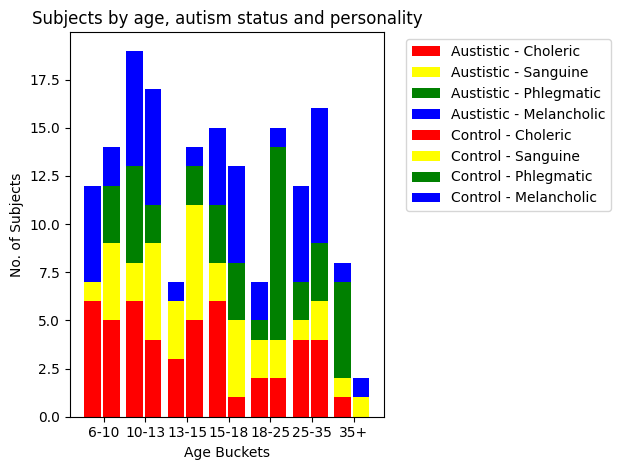

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def get_age_group_index(age):
  if age < 10:
    return 0
  elif age < 13:
    return 1
  elif age < 15:
    return 2
  elif age < 18:
    return 3
  elif age < 25:
    return 4
  elif age < 35:
    return 5
  else:
    return 6

# Example data
categories = ["6-10", "10-13", "13-15", "15-18", "18-25", "25-35", "35+"]  # Categories for the x-axis

personality_encoding = {"choleric": 0, "sanguine": 1, "phlegmatic": 2, "melancholic": 3}

autistic_group = np.array([[0, 0, 0, 0],   # Stacked values for group 1 (first bar of each pair)
                   [0, 0, 0, 0],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0]])  # Values for 4 categories

control_group = np.array([[0, 0, 0, 0],   # Stacked values for group 2 (second bar of each pair)
                   [0, 0, 0, 0],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0]])

for idx, row in tqdm(matched_data.iterrows(), total=matched_data.shape[0]):
  try:
      if row["DX_GROUP"] == 1:
        autistic_group[get_age_group_index(row["AGE_AT_SCAN"])][personality_encoding[row["PERSONALITY"]]] += 1
      else:
        control_group[get_age_group_index(row["AGE_AT_SCAN"])][personality_encoding[row["PERSONALITY"]]] += 1
  except KeyError as e:
      print("Key error, continue to next subject")
      continue

# Number of categories
n = len(categories)

# Bar positions
x = np.arange(n)  # Create positions for each category
bar_width = 0.4   # Width of each bar

print(autistic_group)
print(control_group)

# Create the stacked bar chart

# Stacked bar chart for Group 1
plt.bar(x - bar_width / 1.5, autistic_group[:, 0], width=bar_width, label='Austistic - Choleric', color='red')
plt.bar(x - bar_width / 1.5, autistic_group[:, 1], width=bar_width, bottom=autistic_group[:, 0], label='Austistic - Sanguine', color='yellow')
plt.bar(x - bar_width / 1.5, autistic_group[:, 2], width=bar_width, bottom=autistic_group[:, 0] + autistic_group[:, 1], label='Austistic - Phlegmatic', color='green')
plt.bar(x - bar_width / 1.5, autistic_group[:, 3], width=bar_width, bottom=autistic_group[:, 0] + autistic_group[:, 1] + autistic_group[:, 2], label='Austistic - Melancholic', color='blue')

# Stacked bar chart for Group 2
plt.bar(x + bar_width / 2.2, control_group[:, 0], width=bar_width, label='Control - Choleric', color='red')
plt.bar(x + bar_width / 2.2, control_group[:, 1], width=bar_width, bottom=control_group[:, 0], label='Control - Sanguine', color='yellow')
plt.bar(x + bar_width / 2.2, control_group[:, 2], width=bar_width, bottom=control_group[:, 0] + control_group[:, 1], label='Control - Phlegmatic', color='green')
plt.bar(x + bar_width / 2.2, control_group[:, 3], width=bar_width, bottom=control_group[:, 0] + control_group[:, 1] + control_group[:, 2], label='Control - Melancholic', color='blue')

# Add labels, title, and legend
plt.xlabel('Age Buckets')
plt.ylabel('No. of Subjects')
plt.title('Subjects by age, autism status and personality')
plt.xticks(x, categories)  # Add category labels to x-axis
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))  # Place legend outside the plot

# Show the plot
plt.tight_layout()  # Adjust layout to fit everything
plt.show()
